In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import pprint

import math
from sympy import symbols, Eq, nsolve, sqrt

import pyarrow.parquet as pq

from ipynb.fs.full.Python_Implementation_of_UniSwap_V3 import Get_Price, Get_Tick, Get_Current_Spot_Price, Get_Total_Liquidity, Provide_Liquidity, Withdraw_Liquidity, Swap_Token0_to_Token1, Swap_Token1_to_Token0

# File with data
file_dir = '/Users/zhicong/Dropbox/DEXs'

pool_name = 'USDC-WETH 500 10'
fees = 0.0005

# Liquidity Pool

We will be building history of liquidity pool size from Liquidity Provision data and Swaps data.

## Liquidity Provision

### Load Data

This is cases where liquidity providers mint or burn Uniswap tokens to provide or take out liquidity from the pool.

Since our swap data was downloaded before the LP actions data, we want to take only the LP actions data that are in-line with the swap data.

In [2]:
lp_action = pd.read_csv(os.path.join(file_dir, "Data", "uniswapv3_lp_actions", pool_name + ".csv"))
lp_action.columns = [x.upper() for x in lp_action.columns.tolist()]

# Final cleaning
lp_action['BLOCK_NUMBER'] = lp_action['BLOCK_NUMBER'].astype(int)
lp_action.sort_values(by = ['BLOCK_NUMBER'], ascending = False, inplace = True)
lp_action['AMOUNT0_ADJUSTED'] = lp_action['AMOUNT0_ADJUSTED'].astype(float)
lp_action['AMOUNT1_ADJUSTED'] = lp_action['AMOUNT1_ADJUSTED'].astype(float)
lp_action['BLOCK_TIMESTAMP'] = pd.to_datetime([x[:-5] for x in lp_action['BLOCK_TIMESTAMP'].astype(str)])

# Changing signs of addition and extraction
lp_action['ACTION'] = lp_action['ACTION'].replace({'INCREASE_LIQUIDITY':'Increase Liquidity',
                                                   'DECREASE_LIQUIDITY':'Decrease Liquidity'})
lp_action.rename(columns = {'LIQUIDITY_PROVIDER':'SENDER', 'ACTION':'EVENT_NAME'}, inplace = True)

# Get lower and upper price from tick
lp_action['PRICE_LOWER'] = lp_action['TICK_UPPER'].apply(Get_Price)
lp_action['PRICE_UPPER'] = lp_action['TICK_LOWER'].apply(Get_Price)

# We sort to make single asset deposition last in every block
lp_action['sorter'] = lp_action['AMOUNT0_ADJUSTED']*lp_action['AMOUNT1_ADJUSTED']
lp_action.sort_values(by = ['BLOCK_NUMBER','sorter'], ascending = [True,False], inplace = True)
lp_action.reset_index(drop = True, inplace = True)
lp_action.drop(columns = ['sorter'], inplace = True)

lp_action.head()

,POOL_NAME,TX_HASH,EVENT_NAME,BLOCK_NUMBER,BLOCK_TIMESTAMP,SENDER,NF_TOKEN_ID,AMOUNT0_ADJUSTED,TOKEN0_SYMBOL,AMOUNT0_USD,AMOUNT1_ADJUSTED,TOKEN1_SYMBOL,AMOUNT1_USD,TICK_LOWER,TICK_UPPER,PRICE_LOWER,PRICE_UPPER
0,USDC-WETH 500 10,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,Increase Liquidity,12376729,2021-05-05 21:42:11,0xb2ef52180d1e5f4835f4e343251286fa84743456,977.0,2995.507735,USDC,2995.292327,1.000000,WETH,3437.435736,191150,198080,2499.91359912486268513021059334278106689453125,4998.9181710649063461460173130035400390625
1,USDC-WETH 500 10,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,Decrease Liquidity,12376958,2021-05-05 22:27:41,0xb2ef52180d1e5f4835f4e343251286fa84743456,977.0,2588.187276,USDC,2588.001158,0.931484,WETH,3201.917248,191150,198080,2499.91359912486268513021059334278106689453125,4998.9181710649063461460173130035400390625
2,USDC-WETH 500 10,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,Decrease Liquidity,12376958,2021-05-05 22:27:41,0xb2ef52180d1e5f4835f4e343251286fa84743456,NaN,0.000000,USDC,0.000000,0.000000,WETH,0.000000,191150,198080,2499.91359912486268513021059334278106689453125,4998.9181710649063461460173130035400390625
3,USDC-WETH 500 10,0xa564ea4677bda271bbb2eebec9774577b9b101c46eaf...,Increase Liquidity,12377035,2021-05-05 22:44:11,0x35f5a1ec10deee1256351e37bc78dc80345895f8,1242.0,1.000000,USDC,0.999928,0.000146,WETH,0.500964,194990,195010,3398.18281290132699723471887409687042236328125,3404.98563895004917867481708526611328125
4,USDC-WETH 500 10,0xef93747acabe06ab11f663321f0de466bf9ae35888ba...,Increase Liquidity,12377266,2021-05-05 23:34:39,0x9f9b987becfe15aca93ce9208cca146f252c8d46,1428.0,598.469729,USDC,598.426693,2.600000,WETH,8937.332900,186730,195460,3248.661520935142107191495597362518310546875,7777.2237085991100684623233973979949951171875


## Swaps data

For each swap, we subtract the amount of token out and add the amount of token in. From our swap, column "AMOUNT_IN" indicates the amount of tokens put into the swap and column "AMOUNT_OUT" indicates the amount of token receive from the swap. 

Transaction fees of Uniswap V3 tokens are taken from incoming token and stored elsewhere, therefore the final amount of token entering the pool is (1-transaction_fee)*"AMOUNT_IN" while the final amount of token leaving the pool is simply "AMOUNT_OUT".

In [3]:
swaps = pd.DataFrame(columns = ['BLOCK_NUMBER','BLOCK_TIMESTAMP','TX_HASH','SENDER','TX_TO','PLATFORM','POOL_NAME','CONTRACT_ADDRESS',
                                'EVENT_NAME','AMOUNT_IN','SYMBOL_IN','AMOUNT_OUT','SYMBOL_OUT'])

for i in range(1,4):
    temp = pd.read_parquet(os.path.join(file_dir, "Data", "dex_swaps", pool_name + "_" + str(i) + ".gzip"))
    swaps = pd.concat([swaps,temp], axis = 0)
    del temp

# Final cleaning
swaps.reset_index(drop = True, inplace = True)
swaps['BLOCK_NUMBER'] = swaps['BLOCK_NUMBER'].astype(int)
swaps['AMOUNT_IN'] = swaps['AMOUNT_IN'].astype(float)
swaps['AMOUNT_OUT'] = swaps['AMOUNT_OUT'].astype(float)
swaps['BLOCK_TIMESTAMP'] = pd.to_datetime(swaps['BLOCK_TIMESTAMP'])

# Since the pool charges a transaction fee of 5 basis point on the incoming token, and stored it elsewhere (not in liquidity pool), we subtract that
#swaps['AMOUNT_IN'] = swaps['AMOUNT_IN']*(1-0.0005)

# Changing signs of addition and extraction
swaps['AMOUNT_OUT'] = -swaps['AMOUNT_OUT']
swaps['AMOUNT0_ADJUSTED'] = np.where(swaps['SYMBOL_IN'] == 'WETH', swaps['AMOUNT_OUT'], swaps['AMOUNT_IN'])
swaps['TOKEN0_SYMBOL'] = 'USDC'
swaps['AMOUNT1_ADJUSTED'] = np.where(swaps['SYMBOL_IN'] == 'WETH', swaps['AMOUNT_IN'], swaps['AMOUNT_OUT'])
swaps['TOKEN1_SYMBOL'] = 'WETH'

swaps = swaps[['POOL_NAME','BLOCK_NUMBER','BLOCK_TIMESTAMP','SENDER','EVENT_NAME','AMOUNT0_ADJUSTED','TOKEN0_SYMBOL','AMOUNT1_ADJUSTED','TOKEN1_SYMBOL']]
swaps.sort_values(by = 'BLOCK_NUMBER', ascending = True, inplace = True)
swaps.reset_index(drop = True, inplace = True)

swaps.head()

,POOL_NAME,BLOCK_NUMBER,BLOCK_TIMESTAMP,SENDER,EVENT_NAME,AMOUNT0_ADJUSTED,TOKEN0_SYMBOL,AMOUNT1_ADJUSTED,TOKEN1_SYMBOL
0,USDC-WETH 500 10,12376891,2021-05-05 22:15:01,0xe592427a0aece92de3edee1f18e0157c05861564,Swap,-119.744094,USDC,0.035000,WETH
1,USDC-WETH 500 10,12377278,2021-05-05 23:37:55,0xe592427a0aece92de3edee1f18e0157c05861564,Swap,499.756414,USDC,-0.144241,WETH
2,USDC-WETH 500 10,12377345,2021-05-05 23:51:36,0xe592427a0aece92de3edee1f18e0157c05861564,Swap,365.000000,USDC,-0.103492,WETH
3,USDC-WETH 500 10,12377364,2021-05-05 23:56:34,0xe592427a0aece92de3edee1f18e0157c05861564,Swap,-176.180828,USDC,0.050000,WETH
4,USDC-WETH 500 10,12377369,2021-05-05 23:57:36,0xe592427a0aece92de3edee1f18e0157c05861564,Swap,-514.279985,USDC,0.146000,WETH


### Merging

Now, we want to create a series of events that will cause changes in the liquidity pool size, sorted by block number. This will allow us to build a history of liquidity pool size by blocks.

Important note: Swaps within a block is in the same order of execution

In [4]:
# Removing new LPs
lp_action = lp_action[lp_action['BLOCK_NUMBER'] <= swaps['BLOCK_NUMBER'].max()]
lp_action.reset_index(drop = True, inplace = True)

data = pd.concat([lp_action,swaps], axis = 0)
del swaps, lp_action
data.sort_values(by = 'BLOCK_NUMBER', ascending = True, inplace = True)
data.rename(columns = {'AMOUNT0_ADJUSTED':'Delta USDC', 'AMOUNT1_ADJUSTED':'Delta WETH'}, inplace = True)
data.reset_index(drop = True, inplace = True)
data = data[~((data['Delta WETH'] == 0) & (data['Delta USDC'] == 0))]

data = data[['POOL_NAME','BLOCK_NUMBER','BLOCK_TIMESTAMP','SENDER','EVENT_NAME','Delta WETH','Delta USDC','TICK_LOWER','TICK_UPPER','PRICE_LOWER','PRICE_UPPER']]

data.head()

,POOL_NAME,BLOCK_NUMBER,BLOCK_TIMESTAMP,SENDER,EVENT_NAME,Delta WETH,Delta USDC,TICK_LOWER,TICK_UPPER,PRICE_LOWER,PRICE_UPPER
0,USDC-WETH 500 10,12376729,2021-05-05 21:42:11,0xb2ef52180d1e5f4835f4e343251286fa84743456,Increase Liquidity,1.000000,2995.507735,191150.0,198080.0,2499.91359912486268513021059334278106689453125,4998.9181710649063461460173130035400390625
1,USDC-WETH 500 10,12376891,2021-05-05 22:15:01,0xe592427a0aece92de3edee1f18e0157c05861564,Swap,0.035000,-119.744094,NaN,NaN,NaN,NaN
3,USDC-WETH 500 10,12376958,2021-05-05 22:27:41,0xb2ef52180d1e5f4835f4e343251286fa84743456,Decrease Liquidity,0.931484,2588.187276,191150.0,198080.0,2499.91359912486268513021059334278106689453125,4998.9181710649063461460173130035400390625
4,USDC-WETH 500 10,12377035,2021-05-05 22:44:11,0x35f5a1ec10deee1256351e37bc78dc80345895f8,Increase Liquidity,0.000146,1.000000,194990.0,195010.0,3398.18281290132699723471887409687042236328125,3404.98563895004917867481708526611328125
5,USDC-WETH 500 10,12377266,2021-05-05 23:34:39,0x9f9b987becfe15aca93ce9208cca146f252c8d46,Increase Liquidity,2.600000,598.469729,186730.0,195460.0,3248.661520935142107191495597362518310546875,7777.2237085991100684623233973979949951171875


# The issue is that, with combination of Swap and Liquidity Provision, we are uncertain which one comes first

In [5]:
current_state = {}
current_spot_price = 3443.33391012612
lp_dataframe = pd.DataFrame(columns = ['address','tick_lower','tick_upper','L'])
fees_collected = {}

token0_to_trader = 0
token1_to_trader = 0

# We loop by block number, then by actions in the block, this is so that we can sort actions within a block
for block_num in data.loc[0:1000,'BLOCK_NUMBER'].unique():
    print(block_num)

    temp_df = data[data['BLOCK_NUMBER'] == block_num]
    
    """
    Loop over all actions in every block
    """ 
    while len(temp_df) > 1:
        
        if temp_df['EVENT_NAME'].iloc[0] == "Swap" and temp_df['Delta WETH'].iloc[0] > 0:

            WETH = temp_df['Delta WETH'].iloc[0]
            USDC = -temp_df['Delta USDC'].iloc[0]

            token1_to_trader = Swap_Token0_to_Token1(current_state, current_spot_price, lp_dataframe, fees_collected, WETH, fees)[3]

            # Execute if this is the correct next swap, otherwise append to last row
            if np.abs(USDC/token1_to_trader - 1) < 1e-6:

                current_state, current_spot_price, fees_collected, token1_to_trader = Swap_Token0_to_Token1(current_state, current_spot_price, lp_dataframe, fees_collected, WETH, fees)
                temp_df = temp_df.iloc[1:]
                continue

            else:

                temp_df = pd.concat([temp_df.T, temp_df.iloc[0]], axis = 1).T
                temp_df = temp_df.iloc[1:]
                continue


        elif temp_df['EVENT_NAME'].iloc[0] == "Swap" and temp_df['Delta USDC'].iloc[0] > 0:

            USDC = temp_df['Delta USDC'].iloc[0]
            WETH = -temp_df['Delta WETH'].iloc[0]

            token0_to_trader = Swap_Token1_to_Token0(current_state, current_spot_price, lp_dataframe, fees_collected, USDC, fees)[3]

            # Execute if this is the correct next swap, otherwise append to last row
            if np.abs(WETH/token0_to_trader - 1) < 1e-6:

                current_state, current_spot_price, fees_collected, token0_to_trader = Swap_Token1_to_Token0(current_state, current_spot_price, lp_dataframe, fees_collected, USDC, fees)
                temp_df = temp_df.iloc[1:]
                continue

            else:

                temp_df = pd.concat([temp_df.T, temp_df.iloc[0]], axis = 1).T
                temp_df = temp_df.iloc[1:]
                continue
        

        elif temp_df['EVENT_NAME'].iloc[0] in ["Increase Liquidity","Decrease Liquidity"] and Get_Price(temp_df['TICK_UPPER'].iloc[0]) < current_spot_price < Get_Price(temp_df['TICK_LOWER'].iloc[0]):

            address = temp_df['SENDER'].iloc[0]
            tick_lower = temp_df['TICK_LOWER'].iloc[0]
            tick_upper = temp_df['TICK_UPPER'].iloc[0]
            WETH = temp_df['Delta WETH'].iloc[0]
            USDC = temp_df['Delta USDC'].iloc[0]

            # To determine whether the LP action is before or after the swap within the same block
            if np.abs(Get_Current_Spot_Price(WETH, USDC, Get_Price(tick_upper), Get_Price(tick_lower), current_spot_price)[1]/current_spot_price - 1) < 1e-6:
                
                # If current spot price is same as LP spot price, the LP action is executed here
                if temp_df['EVENT_NAME'].iloc[0] == "Increase Liquidity":
                
                    current_state, current_spot_price, lp_dataframe, fees_collected = Provide_Liquidity(current_state, current_spot_price, lp_dataframe, fees_collected, 
                                                                                                        address, tick_lower, tick_upper, WETH, USDC)
                    temp_df = temp_df.iloc[1:]
                    continue
            
                else:

                    current_state, current_spot_price, lp_dataframe = Withdraw_Liquidity(current_state, current_spot_price, lp_dataframe, address, tick_lower, tick_upper, WETH, USDC)
                    temp_df = temp_df.iloc[1:]
                    continue
            
            else:
                
                # Else, we concat this back to the last row of the actions in this dataframe
                temp_df = pd.concat([temp_df.T, temp_df.iloc[0]], axis = 1).T
                temp_df = temp_df.iloc[1:]
                continue
        
        # Lastly, this is the case of single asset depositions
        else:

            address = temp_df['SENDER'].iloc[0]
            tick_lower = temp_df['TICK_LOWER'].iloc[0]
            tick_upper = temp_df['TICK_UPPER'].iloc[0]
            WETH = temp_df['Delta WETH'].iloc[0]
            USDC = temp_df['Delta USDC'].iloc[0]
                
            if temp_df['EVENT_NAME'].iloc[0] == "Increase Liquidity":
            
                current_state, current_spot_price, lp_dataframe, fees_collected = Provide_Liquidity(current_state, current_spot_price, lp_dataframe, fees_collected, 
                                                                                                    address, tick_lower, tick_upper, WETH, USDC)
                temp_df = temp_df.iloc[1:]
                continue
        
            if temp_df['EVENT_NAME'].iloc[0] == "Decrease Liquidity":

                current_state, current_spot_price, lp_dataframe = Withdraw_Liquidity(current_state, current_spot_price, lp_dataframe, address, tick_lower, tick_upper, WETH, USDC)
                temp_df = temp_df.iloc[1:]
                continue
            

            
    
    """
    Lastly, we need to execute the last action
    """

    if temp_df['EVENT_NAME'].iloc[0] in ["Increase Liquidity","Decrease Liquidity"]:

        address = temp_df['SENDER'].iloc[0]
        tick_lower = temp_df['TICK_LOWER'].iloc[0]
        tick_upper = temp_df['TICK_UPPER'].iloc[0]
        WETH = temp_df['Delta WETH'].iloc[0]
        USDC = temp_df['Delta USDC'].iloc[0]

        if temp_df['EVENT_NAME'].iloc[0] == "Increase Liquidity":
     
            current_state, current_spot_price, lp_dataframe, fees_collected = Provide_Liquidity(current_state, current_spot_price, lp_dataframe, fees_collected, 
                                                                                                address, tick_lower, tick_upper, WETH, USDC)
            continue
            
        else:

            current_state, current_spot_price, lp_dataframe = Withdraw_Liquidity(current_state, current_spot_price, lp_dataframe, address, tick_lower, tick_upper, WETH, USDC)
            continue

    elif temp_df['EVENT_NAME'].iloc[0] == "Swap" and temp_df['Delta WETH'].iloc[0] > 0:

        WETH = temp_df['Delta WETH'].iloc[0]
        USDC = -temp_df['Delta USDC'].iloc[0]
        current_state, current_spot_price, fees_collected, token1_to_trader = Swap_Token0_to_Token1(current_state, current_spot_price, lp_dataframe, fees_collected, WETH, fees)
        if np.abs(USDC/token1_to_trader - 1) > 1e-3:
            raise TypeError("Invalid trade, wrong amount of USDC")
    
    elif temp_df['EVENT_NAME'].iloc[0] == "Swap" and temp_df['Delta USDC'].iloc[0] > 0:

        USDC = temp_df['Delta USDC'].iloc[0]
        WETH = -temp_df['Delta WETH'].iloc[0]
        current_state, current_spot_price, fees_collected, token0_to_trader = Swap_Token1_to_Token0(current_state, current_spot_price, lp_dataframe, fees_collected, USDC, fees)
        if np.abs(WETH/token0_to_trader - 1) > 1e-3:
            raise TypeError("Invalid trade, wrong amount of WETH")



12376729
System Message: Trader sends 0.9999999999 token0 and 2995.507735 token1 into the pool
12376891
System Message: Transfer 119.74409495047284164074562154845856064135026123362 of token1 to trader
12376958
System Message: Trader withdraws 0.9314842499 token0 and 2588.187276 token1 from the pool
12377035
System Message: Trader sends 0.0001457376809 token0 and 1.0 token1 into the pool
12377266
System Message: Trader sends 2.599999996 token0 and 598.469729 token1 into the pool
12377278
System Message: Transfer 0.14424106457027173094140145902286673960863421710870 of token0 to trader
12377308
System Message: Trader sends 0.0 token0 and 3405.610348 token1 into the pool
12377327
System Message: Trader sends 0.1516525269 token0 and 1549.65885 token1 into the pool
12377345
System Message: Transfer 0.10349242846168468706771417252705935919566069897682 of token0 to trader
12377364
System Message: Transfer 176.18082831175100400898884626693106874857502966709 of token1 to trader
12377369
System M

With the Deltas, we can build a history for the size of the liquidity pool.

In [6]:
# Add changes by each block
pool_size = data.groupby(['POOL_NAME','BLOCK_NUMBER','BLOCK_TIMESTAMP']).agg({'Delta USDC':np.sum, 'Delta WETH':np.sum}).reset_index()

# Calculate cumulative values
pool_size['Total USDC'] = pool_size['Delta USDC'].cumsum()
pool_size['Total WETH'] = pool_size['Delta WETH'].cumsum()
pool_size

,POOL_NAME,BLOCK_NUMBER,BLOCK_TIMESTAMP,Delta USDC,Delta WETH,Total USDC,Total WETH
0,USDC-WETH 500 10,12376729,2021-05-05 21:42:11,2995.507735,1.000000,2.995508e+03,1.000000e+00
1,USDC-WETH 500 10,12376891,2021-05-05 22:15:01,-119.744094,0.035000,2.875764e+03,1.035000e+00
2,USDC-WETH 500 10,12376958,2021-05-05 22:27:41,2588.187276,0.931484,5.463951e+03,1.966484e+00
3,USDC-WETH 500 10,12377035,2021-05-05 22:44:11,1.000000,0.000146,5.464951e+03,1.966630e+00
4,USDC-WETH 500 10,12377266,2021-05-05 23:34:39,598.469729,2.600000,6.063421e+03,4.566630e+00
...,...,...,...,...,...,...,...
2611222,USDC-WETH 500 10,17244706,2023-05-12 14:24:47,-196544.641843,110.622216,6.000141e+11,3.668831e+08
2611223,USDC-WETH 500 10,17244707,2023-05-12 14:24:59,2452.506491,-1.379305,6.000141e+11,3.668831e+08
2611224,USDC-WETH 500 10,17244708,2023-05-12 14:25:11,-7003.000000,3.942495,6.000141e+11,3.668831e+08
2611225,USDC-WETH 500 10,17244710,2023-05-12 14:25:35,1500.000000,-0.843620,6.000141e+11,3.668831e+08


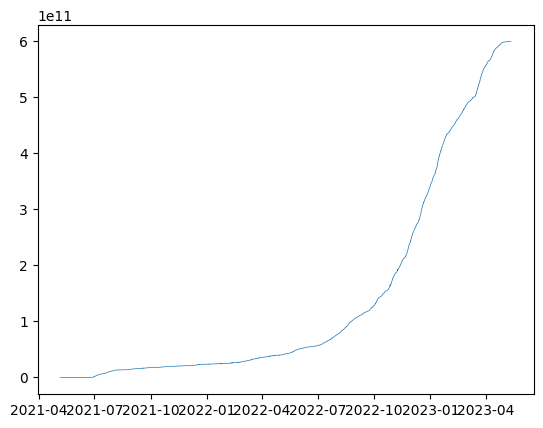

In [7]:
import matplotlib.pyplot as plt

plt.plot(pool_size.BLOCK_TIMESTAMP, pool_size['Total USDC'], linewidth = 0.5)
plt.show()

In [8]:
data[(data['EVENT_NAME'] == 'Swap') & (data['BLOCK_TIMESTAMP'] >= datetime.datetime(2023,3,16)) &
     (data['BLOCK_TIMESTAMP'] < datetime.datetime(2023,3,17))]['Delta USDC'].abs().sum()

433693116.354076